<a href="https://colab.research.google.com/github/tavakohr/rprojects/blob/main/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%load_ext rpy2.ipython
from google.colab import files

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [30]:
%%R
#if (!require("moments")) install.packages("remotes")
#if (!require("moments")) remotes::install_github("feralaes/dampack")

NULL


In [31]:
%%R
if (!require("moments")) install.packages("moments")


In [32]:
%%R
library(tidyverse)
library(repr)
library(moments)
#library(dampack)

# **Step 1 Create Original data set**

In [33]:
%%R
x1 = rnorm(10000)           # some continuous variables
z = 2 + x1       # linear combination with a bias
pr = 1/(1+exp(-z))         # pass through an inv-logit function
y = rbinom(10000,1,pr)      # bernoulli response variable
print( paste('probability in original data set ' ,mean(pr)))

[1] "probability in original data set  0.845515475277624"


In [34]:
%%R
#now feed it to glm:
df1 = data.frame(y=y,x=x1)
model1<-glm( y~x,data=df1,family="binomial")
model1


Call:  glm(formula = y ~ x, family = "binomial", data = df1)

Coefficients:
(Intercept)            x  
      1.981        0.965  

Degrees of Freedom: 9999 Total (i.e. Null);  9998 Residual
Null Deviance:	    8609 
Residual Deviance: 7590 	AIC: 7594


# **Step 2 Create validation data set**

In [35]:
%%R
x2 = rnorm(10000)           # some continuous variables
z2 = 0.2 +  x2       # linear combination with a bias
pr2 = 1/(1+exp(-z2))         # pass through an inv-logit function
y2 = rbinom(10000,1,pr2)      # bernoulli response variable
df2 = data.frame(y=y2,x=x2)

print( paste('probability in vallidation data set ' ,mean(pr2)))

[1] "probability in vallidation data set  0.539016542150476"


In [36]:
%%R
incidence_O<-sum(y)/length(y)
incidence_U<-sum(y2)/length(y2)

## mean of predicted value for original data

In [37]:
%%R
p_original<-predict(model1,newdata=df1,type='response')
mean(p_original)

[1] 0.8455


# mean p of validation vs original 
Although validation's incidence is 0.54 but model1 reports 0.85 

In [38]:
%%R
mean(predict(model1,newdata=df2,type='response'))

[1] 0.8431815


### Responses in validation set  generates by original model

In [39]:
%%R
p=predict(model1,newdata=df2,type='response')


# **Step 3 Calculate the correction factor**

In [40]:
%%R
CF=(incidence_U/(1-incidence_U))/(incidence_O/(1-incidence_O))
CF

[1] 0.2095653


## Transform the responses from original model 

In [41]:
%%R
updated_p=(p*CF)/(1+p*CF-p)

mean(updated_p)


[1] 0.5843544


## mean of transormed response is 0.31 while the correct mean in validation set is 0.22

## create a gold standard response based on validation set

In [42]:
%%R
model2<-glm( y~x,data=df2,family="binomial")
model2
p_reffited=predict(model2,newdata=df2,type='response')
mean(p_reffited)

[1] 0.5342


## probabilities in Original model

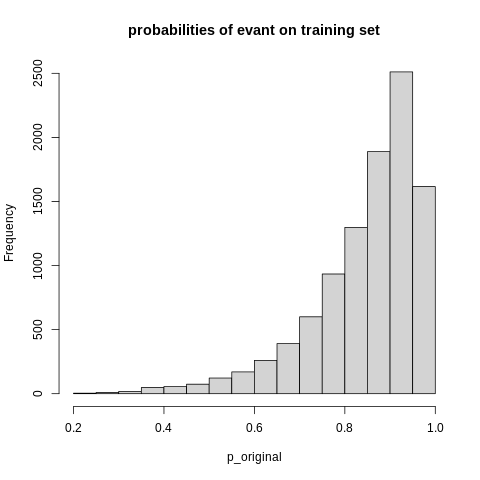

In [43]:
%%R
hist(p_original, main='probabilities of evant on training set')

## comparing the probability set which are associated with validation set
  - 1 updated_p : after converting using CF
  - 2 p_reffited  is provided by refitting a new model on validation set
  - 3 p is probabilities for validation set generated by original model

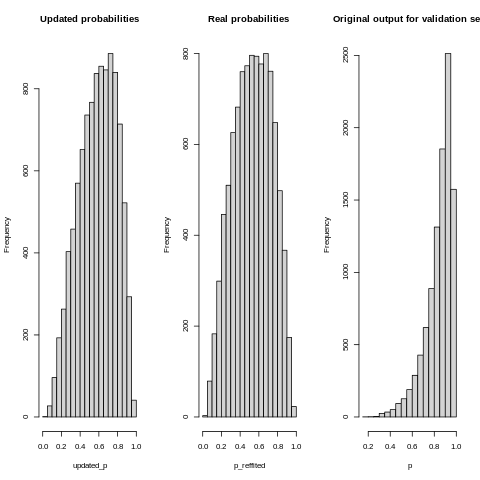

In [44]:
%%R
par(mfrow=c(1,3))

options(repr.plot.width = 2, repr.plot.height =1, repr.plot.res = 600)

hist(updated_p,main="Updated probabilities")
hist(p_reffited,main="Real probabilities ")
hist(p,main="Original output for validation set ")

In [45]:
%%R
print(paste('brier score on original',sum((p-y2)^2)/length(y2)))
print(paste('brier score on updated',sum((updated_p-y2)^2)/length(y2)))
print(paste('brier score on refitted',sum((p_reffited-y2)^2)/length(y2)))

[1] "brier score on original 0.312799093338861"
[1] "brier score on updated 0.209108648569116"
[1] "brier score on refitted 0.206301485012753"


In [46]:
%%R
print(skewness(p_original))

print(skewness(updated_p) )

print(skewness(p_reffited) )

[1] -1.542056
[1] -0.2829169
[1] -0.1120983


# **Step 4 Mohsen's correction factor**

In [47]:
%%R
# k=Mohsen's correction factor
# mu comes from the validation set refitted model
# var also comes from validation set refitted model

mu=mean(p_reffited)
var=var(p_reffited)
print(paste('Hamid corrected mu=',mean(updated_p)))

[1] "Hamid corrected mu= 0.584354360194458"


**1-Mean in original population**


In [48]:
%%R
mean(p_original)

[1] 0.8455


**2-Variance in original population**

In [49]:
%%R
var(p_original)

[1] 0.01453982


**3-Mean in validation population**

In [50]:
%%R
mean(p_reffited)

[1] 0.5342


**4-Variance in validation population**

In [51]:
%%R
var(p_reffited)

[1] 0.04227027


In [52]:
%%R
# Jensen correction
CF

[1] 0.2095653


In [53]:

%%R
#https://www.wolframalpha.com/input/?i=k%2F%281%2Bk%29%2B%281-+k%29k%2F%281-%28%281-k%29%29%2F2%29%5E3*0.01587526+%3D0.54689999999995
#k≈1.2138


k<-1.2138

print(paste('k≈',k))

[1] "k≈ 1.2138"


In [54]:
%%R
odds <- p_original/(1-p_original) * CF
p_new<-odds/(1+odds)
mean(p_new)

[1] 0.5881874


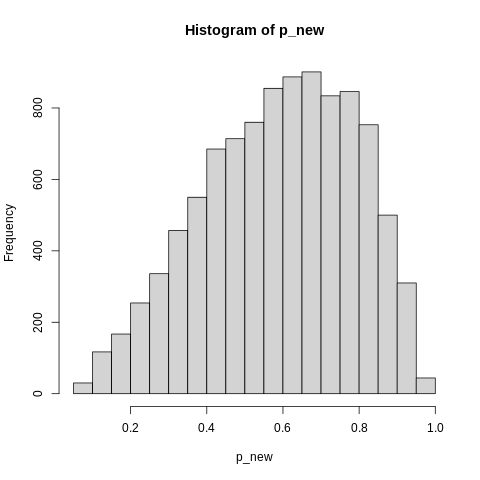

In [55]:
%%R
hist(p_new)